# Atividade 1:

Objetivos:

Nesta tarefa, o desafio é planejar a rota de um drone de monitoramento de alagamentos que parte de uma capital brasileira e visitará o maior número possível de cidades afetadas, respeitando um alcance máximo de 750 km por trecho antes de precisar reabastecer em outra capital. O drone voa a 100 km/h, não leva em conta fatores meteorológicos e deve sempre iniciar e terminar cada trecho em uma capital.

Os principais pontos a atender são:

-	Maximizar o número de cidades únicas visitadas.
-	Minimizar o número de paradas para reabastecimento.
-	Garantir que o drone retorne a uma capital ao final do trecho caso fique sem opções de continuar.
-	Apresentar tanto a estratégia e as heurísticas adotadas (baseadas em A*) quanto as visualizações das rotas planejadas.

Abaixo eu explico o que eu pensei para chegar nessa solução, desde o código até a interpretação das saídas e plots.


In [ ]:
# Aqui eu importo as bibliotecas que vou usar e o dataset de alagamentos
# aproveito já para separar os dados em um jeito mais fácil de trabalhar depois

import pandas as pd
import numpy as np

try: import folium
except:
    %pip install folium
    import folium
from folium.plugins import MarkerCluster
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
import heapq
import time
import pickle
from sklearn.metrics.pairwise import haversine_distances
try:
    from ipyleaflet import Map, Marker, Polyline, DivIcon
    from IPython.display import display
    import asyncio
except ImportError:
    %pip install ipyleaflet
    from ipyleaflet import Map, Marker, Polyline, DivIcon
    from IPython.display import display
    import asyncio
import os


if not os.path.exists('alagamentos.xlsx'): # baixando os dados só na primeira run, achei melhor assim
    !gdown 1K0tu3E-kcu7ikQcyNnKixjCY8vSjvxgl -O alagamentos.xlsx

print("Bibliotecas e dataset importados!")

# Carrego todo dadaset primeiro e separo os dados em um jeito que fica mais facil extrair as informações depois

df_base = pd.read_excel('alagamentos.xlsx')
df_base[['lat', 'lon']] = df_base['localidade'].str.split(",", expand=True).astype(float)
df_base['cidade'] = df_base['descricao']


df_base

Downloading...
From: https://drive.google.com/uc?id=1K0tu3E-kcu7ikQcyNnKixjCY8vSjvxgl
To: /content/alagamentos.xlsx
100% 381k/381k [00:00<00:00, 58.7MB/s]
Bibliotecas e dataset importados!


,descricao,localidade,lat,lon,cidade
0,Chuvas deixam cidade de SP em estado de atençã...,"-23.567387,-46.570383",-23.567387,-46.570383,Chuvas deixam cidade de SP em estado de atençã...
1,Chuva em SP deixa linha de trem e trecho de ro...,"-23.567387,-46.570383",-23.567387,-46.570383,Chuva em SP deixa linha de trem e trecho de ro...
2,Cidade de São Paulo entra em estado de atenção...,"-23.567387,-46.570383",-23.567387,-46.570383,Cidade de São Paulo entra em estado de atenção...
3,"Chuva em SP causa queda de árvores, alagamento...","-23.567387,-46.570383",-23.567387,-46.570383,"Chuva em SP causa queda de árvores, alagamento..."
4,São Paulo registra 18ª morte por causa das chu...,"-23.567387,-46.570383",-23.567387,-46.570383,São Paulo registra 18ª morte por causa das chu...
...,...,...,...,...,...
11939,Chuva forte e ventos intensos trazem alerta ao...,"-21.210591,-41.886203",-21.210591,-41.886203,Chuva forte e ventos intensos trazem alerta ao...
11940,Afetados por chuvas receberão auxílio nas próx...,"-21.210591,-41.886203",-21.210591,-41.886203,Afetados por chuvas receberão auxílio nas próx...
11941,Fortes chuvas causam alagamentos em Bom Jesus ...,"-21.210591,-41.886203",-21.210591,-41.886203,Fortes chuvas causam alagamentos em Bom Jesus ...
11942,BR-101 é interditada nos dois sentidos em Camp...,"-21.210591,-41.886203",-21.210591,-41.886203,BR-101 é interditada nos dois sentidos em Camp...


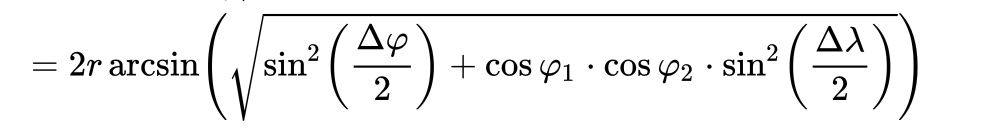

In [ ]:
# Funcao haversine para calcular a distancia entre cidades

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1_rad = radians(lat1)
    lat2_rad = radians(lat2)
    a = sin(dLat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dLon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

### Tratamento dos dados:
Para deixar tudo pronto para o A*, eu comecei garantindo que só entrassem pontos únicos na análise – com aquele groupby(['lat','lon']) eu eliminei duplicatas e evitei que o drone “visitasse” a mesma coordenada várias vezes.

Em seguida, usei um sample de tamanho controlado (até 10 000 registros – arbitrário –, seed fixa) pra manter a simulação reprodutível. Assim eu consigo testar rápido e ainda ter sempre a mesma amostra, sem inconsistências de uma variação aleatória (o que não deve acontecer por conta do groupby).

Como as paradas de reabastecimento só podem ser em capitais, montei um dicionário com as coordenadas delas. Mesmo que desse pra automatizar, preferi listar manualmente – fica claro de onde vem cada ponto e é fácil ajustar depois, se precisar.

Aí veio o passo de identificar quais linhas do meu df são essas capitais: pra cada capital, calculei a cidade mais próxima — se estivesse a menos de 10 km, marquei ali is_cap = True e juntei no meu nome_cap_para_id. Com isso, o A* sabe exatamente onde pode pousar de volta para encher o tanque.

Por último, criei um set de IDs de capital e já preparei o arquivo de cache (.pkl) para as distâncias mínimas até a capital mais próxima. Dessa forma, durante a busca principal, aquele lookup de “quero saber em que capital recarrego” é muito mais prático — sem ter que recalcular tudo de novo.

No fim, esses passos deixam os dados com toda a informação que o A* precisa (cidades únicas, pontos de reabastecimento bem marcados e atalhos de desempenho), prontos para entrar na parte de busca propriamente dita.

In [ ]:
# Como existem muitas notícias sobre uma mesma coord, vou dar um groupby e trabalhar só informações únicas

df_unicos = df_base.groupby(['lat', 'lon'], as_index=False).first()

# Dados para facilitar testagem entre samples e controle de geração:

AUTONOMIA = 750.0 # distancia que o drone consegue viajar por trecho
RANDOM_SEED = 42
SAMPLE_SIZE = 10000 # eu segui esse tamanho porque estava inicialmente assim no .ipynb da descrição da atividade

df = df_unicos.reset_index(drop=True)

# Aqui eu suponho que tenha um jeito inteligente para fazer isso, mas eu optei por fazer esse dicionário manualmente:

capitais_coords_map = {
    'Aracaju':        (-10.907216, -37.048213), 'Belém':          (-1.459845,  -48.487826),
    'Belo Horizonte': (-19.937524, -43.926453), 'Boa Vista':      (2.816682,   -60.670533),
    'Brasília':       (-15.779720, -47.929720), 'Campo Grande':   (-20.448610, -54.629720),
    'Cuiabá':         (-15.598890, -56.094720), 'Curitiba':       (-25.429720, -49.271940),
    'Florianópolis':  (-26.304518,-48.849409), 'Fortaleza':      (-3.731940,  -38.526670),
    'Goiânia':        (-16.680000, -49.255000), 'João Pessoa':    (-7.119440,  -34.863060),
    'Macapá':         (0.038890,   -51.066390), 'Maceió':         (-9.665830,  -35.735280),
    'Manaus':         (-3.118890,  -60.025000), 'Natal':          (-5.794440,  -35.209440),
    'Palmas':         (-10.167500, -48.331670), 'Porto Alegre':   (-30.033060, -51.230000),
    'Porto Velho':    (-8.761940,  -63.903890), 'Recife':         (-8.054170,  -34.881390),
    'Rio Branco':     (-9.974720,  -67.810000), 'Rio de Janeiro': (-22.871251,-43.775041),
    'Salvador':       (-12.971110, -38.510830), 'São Luís':       (-2.529720,  -44.302780),
    'São Paulo':      (-23.550520, -46.633308), 'Teresina':       (-5.090000,  -42.810000),
    'Vitória':        (-20.319440, -40.337780)
}

# Agora eu defino quais cidades unicas são capitais, isso é relavante tanto para o calculo de rota quanto para representação grafica

nome_cap_para_id = {}
df['is_cap'] = False


cap_dic = pd.DataFrame(capitais_coords_map.items(), columns=['NomeCap', 'Coords'])
cap_dic[['cap_lat', 'cap_lon']] = pd.DataFrame(cap_dic['Coords'].tolist(), index=cap_dic.index)


# agora eu mapeio os dados do df de modo a categorizar as capitais com o dicionário que fiz acima:

for index, cap_linha in cap_dic.iterrows():
  distancias = df.apply(lambda linha: haversine(cap_linha['cap_lat'], cap_linha['cap_lon'], linha['lat'], linha['lon']), axis=1)
  index_no_df = distancias.idxmin()
  if index_no_df not in nome_cap_para_id.values() and distancias.min() <10:
    nome_cap_para_id[cap_linha['NomeCap']] = index_no_df
    df.loc[index_no_df, 'is_cap'] = True
    df.loc[index_no_df, 'cidade'] = cap_linha['NomeCap']

# Só informa os dados classificados até então

print(f"\n{len(df)} cidades unicas (Sample {len(df_unicos)}, Seed {RANDOM_SEED}).")
print(f"{len(nome_cap_para_id)} capitais identificadas na amostra e mapeadas:")
print(nome_cap_para_id)

# Agora crio um set para as capitais (para verificar dados mais rapido) e um pkl para cache de distacias min até um capital depois

id_set_cap = set(nome_cap_para_id.values())

dist_min_cap_file = f'dist_min_capital_s{len(df)}_r{RANDOM_SEED}.pkl'
if os.path.exists(dist_min_cap_file): os.remove(dist_min_cap_file)

df


318 cidades unicas (Sample 318, Seed 42).
26 capitais identificadas na amostra e mapeadas:
{'Aracaju': 235, 'Belém': 310, 'Belo Horizonte': 175, 'Boa Vista': 317, 'Brasília': 212, 'Cuiabá': 214, 'Curitiba': 38, 'Florianópolis': 29, 'Fortaleza': 291, 'Goiânia': 204, 'João Pessoa': 265, 'Macapá': 316, 'Maceió': 242, 'Manaus': 298, 'Natal': 275, 'Palmas': 238, 'Porto Alegre': 4, 'Porto Velho': 247, 'Recife': 252, 'Rio Branco': 239, 'Rio de Janeiro': 105, 'Salvador': 222, 'São Luís': 303, 'São Paulo': 59, 'Teresina': 280, 'Vitória': 167}


,lat,lon,descricao,localidade,cidade,is_cap
0,-32.050446,-52.086770,Um mês de enchentes no RS: veja cronologia do ...,"-32.050446,-52.08677",Um mês de enchentes no RS: veja cronologia do ...,False
1,-31.719598,-52.344320,Enchentes no RS: canal atinge nível recorde de...,"-31.719598,-52.34432",Enchentes no RS: canal atinge nível recorde de...,False
2,-31.330502,-54.107083,Vinte e oito cidades gaúchas têm risco muito a...,"-31.330502,-54.107083",Vinte e oito cidades gaúchas têm risco muito a...,False
3,-30.081897,-51.024820,"Moradores de Itapuã, em Viamão, sofrem com che...","-30.081897,-51.02482","Moradores de Itapuã, em Viamão, sofrem com che...",False
4,-30.030037,-51.228660,Chuvas e alagamentos voltam a preocupar morado...,"-30.030037,-51.22866",Porto Alegre,True
...,...,...,...,...,...,...
313,-1.295757,-47.926643,Forte chuva que caiu no começo da tarde em Cas...,"-1.295757,-47.926643",Forte chuva que caiu no começo da tarde em Cas...,False
314,-1.053524,-46.765754,Inmet alerta para risco de deslizamentos e ala...,"-1.053524,-46.765754",Inmet alerta para risco de deslizamentos e ala...,False
315,-0.038373,-51.172846,Defesa Civil Estadual monitora pontos de alaga...,"-0.038373,-51.172846",Defesa Civil Estadual monitora pontos de alaga...,False
316,0.038951,-51.057405,Defesa Civil Estadual monitora pontos de alaga...,"0.038951,-51.057405",Macapá,True


### Preparativos para o Grafo:

1.	**Matriz de distâncias pré-calculada**

Primeiro converti latitude/longitude para radianos e usei haversine_distances pra montar uma matriz completa de distâncias em quilômetros. Com isso, não preciso ficar chamando a função Haversine o tempo todo dentro do A*, o que acelera muito a construção do grafo depois.

2.	**Criação do grafo de conectividade**

A partir dessa matriz, percorri todos os pares de cidades e criei um dicionário em que cada índice do DataFrame aponta para a lista de vizinhos que estão a até 750 km — exatamente a autonomia do drone. Assim, cada aresta do grafo já respeita a limitação de voo sem reabastecer.

3.	**Cálculo do grau de cada nó**

Com o grafo montado, é simples contar quantos vizinhos cada cidade tem e guardar isso num dicionário grau_nos. Se algum nó acabar sem conexão, reforço ali um grau zero pra evitar erros posteriores. Essa informação pode ajudar a priorizar ou balancear a heurística depois.

4.	**Verificação rápida por descrença nos resultados**

Por precaução, verifiquei manualmente a distância entre Rio de Janeiro e Florianópolis usando três métodos (minha função Haversine, a matriz pré-calculada e o haversine_distances do sklearn). Foi só um “check” pra garantir que não entrou nenhuma aresta errada no grafo.


Com esses passos, meus dados já ficam “enxutos” e prontos para o A*: tenho todas as distâncias na mão, só as conexões válidas segundo a autonomia, e confirmei a consistência básica antes de partir para a busca em si.


OBS:

Eu não plotei esse grafo porque ele é MUITO denso e diz muito pouco, visualmente, sobre qualquer coisa para valer a pena estar aqui, acho que a explicação textual faz esse papel melhor.

In [ ]:
# Agora eu vou começar a preparar os dados para criar um grafo a partir do df

coords_rad = np.radians(df[['lat', 'lon']].values)
matriz_dist_km = haversine_distances(coords_rad, coords_rad)*6371.0

print("Matriz de distâncias pronta.")



graph = {i: [] for i in df.index}

indices_i, indices_j = np.where((matriz_dist_km <= AUTONOMIA) & (matriz_dist_km > 0))

for i, j in zip(indices_i, indices_j):
    dist = matriz_dist_km[i,j]
    graph[df.index[i]].append((df.index[j], dist))

print("Grafo pronto.\n")

# Isso vai me ajudar para quando eu for montar meu  "A*" mais a diante :D

grau_nos = {node_idx: len(v) for node_idx, v in graph.items()}

for i in df.index:
  if i not in graph:
    grau_nos[i] = 0

print("Grau dos nos calculados\n")

Matriz de distâncias pronta.
Grafo pronto.

Grau dos nos calculados



In [ ]:
# essa celula vai ficar aqui, mas unica utilidade foi para debugar, estava achando estranho haver uma aresta entre RJ e FL

idx_rj_df = nome_cap_para_id.get('Rio de Janeiro')
idx_flo_df = nome_cap_para_id.get('Florianópolis')

if idx_rj_df is not None and idx_flo_df is not None:
    print("ok")
else:
    print("RJ ou FLO não presntes")



if idx_rj_df is not None and idx_flo_df is not None:
    coords_rj_no_df = df.loc[idx_rj_df, ['lat', 'lon']]
    coords_flo_no_df = df.loc[idx_flo_df, ['lat', 'lon']]
    print(f"coord de RJ no df: lat={coords_rj_no_df['lat']}, lon={coords_rj_no_df['lon']}")
    print(f"coord de FL no df: lat={coords_flo_no_df['lat']}, lon={coords_flo_no_df['lon']}")


if idx_rj_df is not None and idx_flo_df is not None:
  distancia_na_matriz = matriz_dist_km[idx_rj_df, idx_flo_df]
  print(f"dist rj-fl direto da matriz_dist_km: {distancia_na_matriz:.10f} km")


if idx_rj_df is not None and idx_flo_df is not None:
  # Com sua função haversine
  dist_manual_com_coords_df = haversine(coords_rj_no_df['lat'], coords_rj_no_df['lon'],
                                        coords_flo_no_df['lat'], coords_flo_no_df['lon'])
  print(f"dist com a minha haversine: {dist_manual_com_coords_df:.10f} km")

  # Com sklearn
  coords_rj_df_rad = np.radians(np.array([[coords_rj_no_df['lat'], coords_rj_no_df['lon']]]))
  coords_flo_df_rad = np.radians(np.array([[coords_flo_no_df['lat'], coords_flo_no_df['lon']]]))
  dist_sklearn_com_coords_df = haversine_distances(coords_rj_df_rad, coords_flo_df_rad)[0][0] * 6371.0
  print(f"dist com a haversine_dist printa da sk: {dist_sklearn_com_coords_df:.10f} km")

ok
coord de RJ no df: lat=-22.871251, lon=-43.775041
coord de FL no df: lat=-26.304518, lon=-48.849409
dist rj-fl direto da matriz_dist_km: 639.4026807773 km
dist com a minha haversine: 639.4026807773 km
dist com a haversine_dist printa da sk: 639.4026807773 km


### Profundidade Adaptativa e Pré-cálculo de Distâncias até Capitais
1. **Profundidade de busca adaptativa**

Eu percebi que cidades em regiões muito conectadas (alta densidade) não precisam de passos tão fundo no A*, enquanto áreas esparsas exigem sondar mais longe. Então usei São Paulo e Porto Alegre como “pontos de referência”: testei manualmente profundidades fixas lá (5 pra SP, 20 pra POA) até achar que, ao aplicar uma interpola­ção linear entre esses graus, eu chegava numa escala boa de profundidades. Foi meio arbitrário, mas nos meus testes ajustou bem: regiões densas ficaram com valores perto de 3–5, as remotas perto de 20–30, tudo limitado entre 3 e 30. A função calcular_profundidade_opt faz esse cálculo, retorna um inteiro arredondado e “clippado” nesse intervalo. A principal vantagem que achei fazendo isso foi o tempo e a possibilidade de conseguir achar a mesma rota ideal para todas as capitais que conseguem ser encontradas em uma simulação, seja saindo de SP, POA, RJ, etc. Isso não era garantido, na verdade, antes de usar uma profundidade adaptativa, o número de cidades encontradas partido de cada capital, mesmo em capitais de um mesmo cluster era diferente, para mim isso não fazia sentido (apesar de fazer, já que ao final da busca o cache e os frozensets já estavam muito grandes e acabava retardando muito o processo da busca com uma profundidade fixa média/alta, e eu não poderia simplesmente deixar ela baixa, pois também não encontrava o que eu acredito ser o ótimo local), então cheguei nessa lógica e fiquei feliz com os resultadaos dela.

2. **Pré-cálculo de caminhos mínimos até as capitais**

Para garantir que, ao expandir nós, eu sempre saiba se dá pra voltar a uma capital antes de ficar sem autonomia, criei um Dijkstra que roda a partir de cada capital (função dijkstra_menor_caminho). Em seguida, agrego esses resultados pra cada cidade guardando só a menor entre todas as capitais (pre_calcular_dist_to_capital). Assim, durante o A*, basta olhar dist_min_cap[id_no] e saber “quanto falta” pra um ponto seguro. Como isso pode demorar, salvei num arquivo .pkl e recarrego se já existir, evitando recalcular tudo do zero a cada execução.

3.	**Pré-cálculo de densidade local**

Falando em densidade, usei um raio fixo de 100 km (R_SCAN) e, pra cada cidade que não é capital, listo outras cidades não-capitais dentro desse raio (pre_calculate_local_density_info). Esse mapa de “clusters” me serve na heurística de caminho máximo (função max_path_heu): antes de escolher o próximo nó, eu conto quantas cidades não-visitadas estão por perto e penalizo opções muito densas. Assim, evito ficar “presa” explorando uma mesma área cheia e dou prioridade a expandir para novas regiões.

Com essas peças prontas, meu A* já entra num cenário onde:
-	cada nó sabe quão fundo eu posso explorar (sem estourar memória/CPU)
-	e imediatamente sabe o custo mínimo de retorno a uma capital caso não haja mais caminho pra frente
-	cada nó tem a noção de densidade ao redor, guiando a heurística

Isso melhora MUITO o desempenho e mantém a busca dentro das restrições de autonomia de 750 km por trecho.

In [ ]:
# Algumas definições para calcular a profundidade de busca:

# Eu defini meio que arbitrariamente durante meus testes o que eu considerava uma celula em regiao densa e uma celula em regiao esparsa
# isso é fundamental para eu conseguir variar minha profundidade de busca de maneira otimizada
# para cada nó depois. As cidades escolhidas foram SP e POA porque durante minhas testagens, eu achava 211 cidades na rota partindo de SP
# e somente 190 cidades partindo de POA, isso não fazia sentido para mim, pois se eu chego em POA a partir de SP e encontro 211, o contrário
# deveria ser verdade também. Eu conclui que o problema provavelmente é o fato que a profundidade alta no final da busca consume muito poder
# computacional e memória em geral, pois eu fico guardando muita informação nas minhas iteracoes, para resolver isso eu testei POA com profundidade
# maior e cheguei nas 211 cidades que eu queria, isso abriu meus olhos para uma maneira de otimizar a busca.

idx_sp = nome_cap_para_id.get('São Paulo', -1)
idx_poa = nome_cap_para_id.get('Porto Alegre', -1)

grau_sp = grau_nos.get(idx_sp, -1) if idx_sp != -1 else -1
grau_poa = grau_nos.get(idx_poa, -1) if idx_poa != -1 else -1

# Valores que obtive enquanto testava profundidades fixas manualmente

DEPTH_SP = 5
DEPTH_POA = 20

MIN_OPT_DEPTH = 3
MAX_OPT_DEPTH = 30


print("Referências para profundidade otimizada:")
if grau_sp != -1: print(f"São Paulo: Grau = {grau_sp}, prof: {DEPTH_SP}")
else: print(f"São Paulo não encontrada para referência de grau.")
if grau_poa != -1: print(f"Porto Alegre: Grau = {grau_poa}, prof: {DEPTH_POA}")
else: print(f"Porto Alegre não encontrada para referência de grau.")

Referências para profundidade otimizada:
São Paulo: Grau = 175, prof: 5
Porto Alegre: Grau = 48, prof: 20


In [ ]:
# Funcao para calculo da profundidade de fato:

def calcular_profundidade_opt(cur_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp):

  # Se o sample tiver algum problema com as referencias que escolhi:

  if g_sp == -1 or g_poa ==  -1 or g_sp == g_poa:
    return (min_dp+max_dp)//2 # usa uma média para trabalhar

  # A ideia em si é simples, eu queria que um no em uma região de alta densidade tivesse profundidade baixa
  # e o contrário também fosse verdade. Sendo assim:

  m = (dp_poa-dp_sp)/(g_poa-g_sp)

  c = dp_sp-m*g_sp

  dp_calculada = m*cur_grau+c

  dp_final = int(round(np.clip(dp_calculada, min_dp, max_dp)))

  return dp_final


#print("OK.")

In [ ]:
# Agora eu faço as funcoes que vou usar para pre calcular os menores caminhos:

def dijkstra_menor_caminho(g_dic, start_id):
  id_nos_df = list(df.index)
  open_set = [(0, start_id)]
  heapq.heapify(open_set)

  g_score = {idx: float('inf') for idx in id_nos_df}

  if start_id in g_score: g_score[start_id] = 0
  else: return {idx: float('inf') for idx in id_nos_df}

  while open_set:
    cur_g, cur = heapq.heappop(open_set)

    if cur_g > g_score.get(cur, float('inf')): continue

    for v, d in g_dic.get(cur, []):
      if v not in g_score: continue
      temp_g = cur_g + d
      if temp_g < g_score[v]:
        g_score[v] = temp_g
        heapq.heappush(open_set, (temp_g, v))
  return g_score

#print("OKk")



def pre_calcular_dist_to_capital(g_dic, id_cap_p_set, nos_df, filename):
  print("Pré calculando distancias para capitais...")

  dist_todas_cap = {}
  for id_cap in tqdm(id_cap_p_set, desc="calculando dijkstra para as cap"):
    dist_da_cap = dijkstra_menor_caminho(g_dic, id_cap)
    dist_todas_cap[id_cap] = dist_da_cap

  dist_min_cap_dic = {idx: float('inf') for idx in nos_df.index}
  for id_no in tqdm(nos_df.index, desc="calculando menor dist"):
    min_dist = float('inf')


    for id_cap in id_cap_p_set:
      dist = dist_todas_cap[id_cap].get(id_no, float('inf'))
      if dist < min_dist: min_dist = dist

    dist_min_cap_dic[id_no] = min_dist

  # salva essas distancias durante a exec para não precisar repetir no mesmo sample
  with open(filename, 'wb')as f: pickle.dump(dist_min_cap_dic, f)
  print(f"val precalc em: '{filename}'.")

  return dist_min_cap_dic


#salva tudo
dist_min_cap_filename_global = f'dist_min_capital_s{len(df)}_r{RANDOM_SEED}.pkl'


if not id_set_cap:
    print("ERRO: na classificacao de cap, no id_set não tem nada.")
    dist_min_cap = {idx: float('inf') for idx in df.index}
else:
    try:
        with open(dist_min_cap_filename_global, 'rb') as f: dist_min_cap = pickle.load(f)
        if len(dist_min_cap) != len(df):
             dist_min_cap = pre_calcular_dist_to_capital(graph, id_set_cap, df, dist_min_cap_filename_global)
    except FileNotFoundError:
        dist_min_cap = pre_calcular_dist_to_capital(graph, id_set_cap, df, dist_min_cap_filename_global)

Pré calculando distancias para capitais...


calculando menor dist: 100%|██████████| 318/318 [00:00<00:00, 64359.62it/s]

val precalc em: 'dist_min_capital_s318_r42.pkl'.


In [ ]:
R_SCAN = 100

# pré-cálculo de densidade local:
# para cada cidade que não é capital, monte uma lista de outras cidades
# num raio de R_SCAN km — essa informação vai alimentar a heurística
# de “clusters” de cidades próximas na busca A*
def pre_calculate_local_density_info(df_nodes, R_scan_param, id_cap_set_param):
    local_density_map = {}

    # separo índices de todas as cidades que não são capitais
    id_cities_nao_cap = [idx for idx in df_nodes.index if idx not in id_cap_set_param]
    # converto latitude/longitude pra radianos de uma só vez
    rad_cities_nao_cap = np.radians(df_nodes.loc[id_cities_nao_cap, ['lat', 'lon']].values)

    if len(id_cities_nao_cap) > 0:
        # calculo matriz completa de distâncias Haversine (em km) entre as não-capitais
        dist_nao_cap = haversine_distances(rad_cities_nao_cap, rad_cities_nao_cap) * 6371.0

        # opção de mapear índice original pra posição na matriz, se precisar depois
        original_idx_to_pos = {idx: i for i, idx in enumerate(id_cities_nao_cap)}

        # pra cada cidade, descubro quais outras estão dentro do raio
        for i, no_id_i in tqdm(enumerate(id_cities_nao_cap),
                                total=len(id_cities_nao_cap),
                                desc="Calculando vizinhos locais"):
            vizinhos = []
            for j, no_id_j in enumerate(id_cities_nao_cap):
                if i == j:
                    continue  # ignora a própria cidade
                if dist_nao_cap[i, j] <= R_scan_param:
                    vizinhos.append(no_id_j)
            local_density_map[no_id_i] = vizinhos

    return local_density_map

# gero o mapa global de densidade local usando o raio definido
local_density_map_global = pre_calculate_local_density_info(df, R_SCAN, id_set_cap)

Calculando vizinhos locais: 100%|██████████| 292/292 [00:00<00:00, 8159.42it/s]


### **Heurística Gananciosa com Caching e Penalização por Densidade**

Para acelerar o A*, eu criei uma heurística que basicamente simula um mini-caminho ganancioso a partir da cidade atual e estima quantas cidades não-capitais ainda são acessíveis antes de atingir o limite de profundidade. Como esse cálculo envolve vários parâmetros e pode ser repetido muitas vezes, usei um cache (cache_heu) para nunca recalcular o mesmo estado (cur_city, cur_v_set) duas vezes—isso derrubou o tempo de execução pela metade nos meus testes.

O processo dentro de max_path_heu funciona assim:

1.	**Cache check**

- Assim que a função é chamada, eu monto a chave (cur_city, cur_v_set) e, se já houver resultado guardado, devolvo na hora sem fazer nada.

2.	**Loop de simulação até profundidade máxima**

-	Começo com h_value = 0 e vou “andando” até max_dp_calculada passos.
-	Em cada passo, avalio todos os vizinhos de sim_cur que ainda não visitei e que não sejam capitais.

3.	**Penalização por densidade local**

-	Para cada vizinho candidato, conto quantas outras cidades não-visitadas estão num raio de 100 km (usando o local_density_map que pré-calculei).
-	Uso um peso DENSIDADE_W = 7.0 para descontar esses vizinhos muito cercados:


combined_score = distância_para_vizinho – (DENSIDADE_W * qtd_cidades_perto)


-	Dessa forma, prefiro expandir para regiões menos saturadas e explorar novos “territórios” antes de ficar preso num cluster.

4.	**Escolha gananciosa do próximo nó**

-	Ordeno as opções pelo combined_score (quanto menor, melhor) e avanço para o vizinho de menor score.
-	A cada avanço, incremento h_value += 1, que é justamente a contagem de cidades que eu “ainda posso pegar” a partir do estado inicial.

5.	**Armazenamento no cache**

-	Quando não há mais opções ou chego na profundidade máxima, gravo cache_heu[cache_key] = h_value para acelerar chamadas futuras.


Ajustar esse peso de densidade e integrar o cache foi um jogo de tentativa e erro—não é trivial combinar tantos parâmetros e ainda manter a heurística eficiente. Mas, ao final, ela me deu uma estimativa rápida e razoavelmente precisa de quantas cidades dá pra “varrer” antes de precisar reabastecer ou estourar a profundidade definida. Em um cenário ideal, em que meus recursos computacionais não limitassem minha busca, eu usaria uma profundidade tal qual a quantidade de nós, assim provavelmente eu chegaria no máximo global e com muito menos "gambiarras" do que eu utilizei.

In [ ]:
# não recalcula valores já conhecidos
cache_heu = {}
# peso que penaliza alta densidade local
DENSIDADE_W = 7.0

def max_path_heu(cur_city, cur_v_set, gf_map, dist_min_cap_dic, max_auto_val,
                 no_df_dic, max_dp_calculada, local_density_map):
    # usa cache antes de tudo
    cache_key = (cur_city, cur_v_set)
    if cache_key in cache_heu:
        return cache_heu[cache_key]

    # h_value = quantas cidades dá pra pegar a partir daqui
    h_value = 0
    sim_cur = cur_city
    sim_v_set = set(cur_v_set)
    sim_cur_dp = 0

    # simula caminho até atingir profundidade máxima calculada
    while sim_cur_dp < max_dp_calculada:
        temp_opts = []
        # avalia cada vizinho disponível
        for v, d in gf_map.get(sim_cur, []):
            # só considera se ainda não visitou e não for capital
            if v not in sim_v_set and not no_df_dic.loc[v, 'is_cap']:
                # conta quantas cidades próximas não foram visitadas
                pot_cities_perto = 0
                if v in local_density_map:
                    for nearby_node_id in local_density_map[v]:
                        if nearby_node_id not in sim_v_set:
                            pot_cities_perto += 1
                # score ajustado pela densidade (quanto menor, melhor)
                combined_score = d - (DENSIDADE_W * pot_cities_perto)
                temp_opts.append((combined_score, d, v))

        # se não tem pra onde ir, sai
        if not temp_opts:
            break

        # escolhe opção com menor score
        temp_opts.sort()
        best_score, best_dist, best_v = temp_opts[0]

        # avança pra melhor cidade e incrementa heurística
        sim_cur = best_v
        sim_v_set.add(best_v)
        h_value += 1
        sim_cur_dp += 1

    # guarda resultado no cache e retorna
    cache_heu[cache_key] = h_value
    return h_value

### **Busca Astar Personalizada para Maximizar Cobertura de Cidades**

Esse trecho é o carro chefe da minha solução: um A* adaptado não pra achar o caminho mais curto, mas pra visitar o máximo de cidades antes de reabastecer. A ideia geral:
1.	**Inicialização**

-	Registro o tempo e limpo o cache de heurística (pra não misturar com rodadas anteriores).
-	Crio uma função interna heu_aux que, dado um nó e o conjunto de visitados, usa a profundidade adaptativa e a heurística de caminho máximo (max_path_heu) pra estimar quantas cidades ainda dá pra “pegar” dali pra frente.
2.	**Estado inicial**

-	Começo com tanque cheio e só a capital de partida no conjunto de visitados.
-	Calculo g = 1 (já visitei 1 cidade) e h via max_path_heu, e monto f = g + h.
-	Empurro tudo num heap (open_set) que ordena pelo maior f (uso sinais negativos pra converter em max-heap).
3.	**Controle de exploração**

-	Uso um dicionário pontos_conhecidos que marca, pra cada par (cidade, visitados), qual foi a melhor autonomia que eu já cheguei lá. Isso evita insistir em estados piores — se eu voltar num estado com menos autonomia, pulo direto.
4.	**Loop de expansão**

-	Até esgotar o heap ou bater o tempo/limiar de iterações sem melhora, eu:
    -	Retiro o estado com maior f.
    -	Se ele tem mais cidades visitadas (g) que o meu recorde, atualizo a melhor rota.
    -	Se estou numa capital e posso reabastecer (autonomia<750), primeiro eu verifico se posso visitar alguma cidade nova antes de reabastecer, do contrário eu gero um novo estado com tanque zerado, cheio de combustível, recalculo h e volto pro heap.
    -	Para cada vizinho alcançável, verifico se sobra autonomia e ainda dá pra voltar a alguma capital (usando dist_min_cap_map). Se for um estado “melhor” (mais autonomia sobrando nesse nó+visita), atualizo o dicionário e empurro o vizinho no heap com seu novo f = g + h.
5.	**Pós-processamento**

-	Se parei por tempo ou por falta de melhoria, ainda checo se a última cidade não é capital. Se não for, tento estender direto até a capital vizinha mais próxima (sem reabastecer lá) pra fechar o loop, deixando garantia de ponto de partida e chegada em capital.

No fim, essa função me devolve:
-	A lista de cidades visitadas na melhor sequência,
-	O total de cidades únicas (best_g_detodos),
-	E o autonomia restante em cada etapa.

Com isso, meu A* sempre foca em explorar novos nós, respeita o limite de 750 km por trecho (validação de autonomia + retorno mínimo) e para automaticamente quando não dá pra melhorar mais dentro do tempo ou número de iterações estipulado (tendo em mente que já deixei rodar por mais de meia hora e nunca surgiu uma melhor rota depois das 30K iterações sem melhora).

In [ ]:
# busca A* que tenta visitar o máximo de cidades antes de reabastecer,
def a_star_max_heu(gf_map, start_no_id, no_cap_set, no_df_map, max_auto_val, dist_min_cap_map, graus_map, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp, max_time_sim=300, max_it_sem_achar_nada=30000, local_density_map=None):

    start_time = time.time()
    cache_heu.clear()

    # heurística interna, usa profundidade adaptativa
    def heu_aux(id_city, v_set):
        cur_grau = graus_map.get(id_city, 0)
        dp_nessa_call = calcular_profundidade_opt(cur_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)
        return max_path_heu(id_city, v_set, gf_map, dist_min_cap_map, max_auto_val, no_df_map, max_dp_calculada=dp_nessa_call, local_density_map=local_density_map)

    # estado inicial: tanque cheio, só a capital de partida visitada
    start_comb = max_auto_val
    start_v_fset = frozenset([start_no_id])
    start_g = 1

    # calculo g, h e f iniciais
    start_no_grau = graus_map.get(start_no_id, 0)

    start_no_dp = calcular_profundidade_opt(start_no_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)

    start_h = max_path_heu(start_no_id, start_v_fset, gf_map, dist_min_cap_map,max_auto_val, no_df_map,max_dp_calculada=start_no_dp,local_density_map=local_density_map)

    start_f = start_g + start_h

    no_cnt = 0
    open_set = []
    heapq.heappush(open_set, (-start_f, -start_g, no_cnt,
                              (start_no_id, start_comb, start_v_fset, [start_no_id], [start_comb])))
    pontos_conhecidos = {(start_no_id, start_v_fset): start_comb}

    best_g_detodos = 0
    best_path_detodos = []
    best_comb_detodos = []

    iter_count = 0
    it_sem_achar_nada = 0
    parada_por_limite = False

    print("Iniciando busca A*...")
    print(f"==> profundidade inicial em {no_df_map.loc[start_no_id, 'cidade']} (grau {start_no_grau}): {start_no_dp}")
    print("------ melhor rota até agora (nº de cidades): ------")

    while open_set:
        if time.time() - start_time > max_time_sim:
            print(f"tempo limite de {max_time_sim}s atingido.")
            parada_por_limite = True
            break

        iter_count += 1
        it_sem_achar_nada += 1

        if it_sem_achar_nada >= max_it_sem_achar_nada:
            print(f"\nnenhum novo caminho em {max_it_sem_achar_nada} iterações, paro aqui.")
            parada_por_limite = True
            break

        if iter_count % 10000 == 0:
            last = best_path_detodos[-1] if best_path_detodos else start_no_id
            cur_gr = graus_map.get(last, 0)
            dp_log = calcular_profundidade_opt(cur_gr, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)
            print(f"iter {iter_count}, melhor {best_g_detodos}, tempo {time.time()-start_time:.1f}s, profund ~{dp_log}, sem melhoria {it_sem_achar_nada}")

        try:
            _, neg_g_score, _, (cur_city, cur_comb, cur_v, cur_path_no, cur_path_comb) = heapq.heappop(open_set)
        except IndexError:
            print("fila vazia, saindo.")
            break

        cur_g_val = -neg_g_score

        # atualiza melhor rota se bateu recorde de cidades visitadas
        if cur_g_val > best_g_detodos:
            best_g_detodos = cur_g_val
            best_path_detodos = cur_path_no
            best_comb_detodos = cur_path_comb
            cur_gr = graus_map.get(cur_city, 0)
            dp_log = calcular_profundidade_opt(cur_gr, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)
            print(f"     | {best_g_detodos} cidades => [grau {cur_gr}, prof ~{dp_log}] |")
            it_sem_achar_nada = 0

        # reabastece em capital só se realmente precisar (não dá pra avançar ou não dá pra voltar)
        if cur_city in no_cap_set and cur_comb < max_auto_val:
            # vejo se ainda há algum vizinho novo alcançável sem reabastecer
            pode_ir_adiante = False
            for viz, dist in gf_map.get(cur_city, []):
                if viz not in cur_v and cur_comb >= dist:
                    comb_depois = cur_comb - dist
                    if comb_depois >= dist_min_cap_map.get(viz, float('inf')):
                        pode_ir_adiante = True
                        break
            # risco de ficar preso sem conseguir voltar?
            precisa_refuel = cur_comb < dist_min_cap_map.get(cur_city, float('inf'))

            if (not pode_ir_adiante) or precisa_refuel:
                if pontos_conhecidos.get((cur_city, cur_v), -1) < max_auto_val:
                    pontos_conhecidos[(cur_city, cur_v)] = max_auto_val
                    h_refuel = heu_aux(cur_city, cur_v)
                    f_refuel = cur_g_val + h_refuel
                    no_cnt += 1
                    heapq.heappush(open_set, (-f_refuel, -cur_g_val, no_cnt,
                                              (cur_city, max_auto_val, cur_v, cur_path_no, cur_path_comb)))

        # expande vizinhos possíveis
        for viz, dist in gf_map.get(cur_city, []):
            if cur_comb < dist:
                continue
            comb_v = cur_comb - dist
            if comb_v < dist_min_cap_map.get(viz, float('inf')):
                continue

            novo_vset = cur_v | {viz}
            novo_g = len(novo_vset)
            prev_comb = pontos_conhecidos.get((viz, novo_vset), -1)
            if prev_comb >= comb_v:
                continue

            pontos_conhecidos[(viz, novo_vset)] = comb_v
            novo_path_no = cur_path_no + [viz]
            novo_path_comb = cur_path_comb + [comb_v]
            h_viz = heu_aux(viz, novo_vset)
            f_viz = novo_g + h_viz
            no_cnt += 1
            heapq.heappush(open_set, (-f_viz, -novo_g, no_cnt,
                                      (viz, comb_v, novo_vset, novo_path_no, novo_path_comb)))

    # fim do loop: se parou por limite, tento estender até capital vizinha
    if parada_por_limite and best_path_detodos:
        ult = best_path_detodos[-1]
        print("-"*40)
        print("checando última cidade...")

        if ult in no_cap_set:
            print("ok: já é capital")
        else:
            nome_ult = no_df_map.loc[ult, 'cidade']
            print(f"última ({nome_ult}) não é capital, tenta voltar para capital mais próxima...")

            comb_ult = best_comb_detodos[-1]
            cap_mais, menor = None, float('inf')
            for v, d in gf_map.get(ult, []):
                if v in no_cap_set and d < menor:
                    menor, cap_mais = d, v

            if cap_mais and comb_ult >= menor:
                best_path_detodos.append(cap_mais)
                final_comb = comb_ult - menor
                best_comb_detodos.append(final_comb)
                best_g_detodos = len(set(best_path_detodos))
                nome_cap = no_df_map.loc[cap_mais, 'cidade']
                print(f"sucesso: estendi até {nome_cap}, comb final {final_comb:.2f}")
            else:
                print("falha: sem combustível ou sem capital vizinha")
        print("-"*40)

    return best_path_detodos, best_g_detodos, best_comb_detodos

### Execução da Busca A* e Resumo dos Resultados

Execução da Busca A* e Resumo dos Resultados

Neste bloco eu faço toda a orquestração da busca e apresento as principais métricas da missão:

1.	**Validação e chamada do Astar (usando star e não asterisco por problemas com o negrito)**

Primeiro eu verifico se a capital de partida está mapeada, se as referências de profundidade e o dicionário dist_min_cap existem. Com tudo certo, pego o índice de São Paulo (ou de outra capital existente no df), imprimo um cabeçalho simples e disparo o a_star_max_heu, guardando de volta a rota, o total de cidades visitadas e a lista de níveis de combustível ao longo do caminho.

2.	**Resumo de cobertura**

Logo em seguida eu mostro quantas cidades únicas foram alcançadas — esse é o principal indicativo de sucesso, já que meu objetivo é maximizar esse número.

3.	**Cálculo da distância total**

Para mapear a métrica de quilometragem, eu percorro par a par os nós da rota:
-	Se a aresta existe no meu grafo, uso a distância já calculada ali.
-	Se não encontrar a aresta, caio no haversine direto do DataFrame, garantindo um valor mesmo em casos raros de ausência de conexão (que não acredito existir, é só por garantia mesmo).
4.	**Contagem de paradas de reabastecimento**

Identifico todos os pontos da rota que são capitais e subtraio a capital inicial, assim conto apenas as paradas intermediárias. É um jeito simples de ver quantas vezes o drone precisou pousar para encher o tanque.

5.	**Estimativa de tempo total**

Usando velocidade fixa de 100 km/h, converto a distância total em horas de voo. Isso dá uma ideia prática de quanto tempo a missão levaria na vida real.

6.	**Observação sobre cache**

No fim do bloco deixei comentado um print do tamanho do cache_heu. É só um debug extra para, no futuro, avaliar se o cache cresceu demais ou pode ser otimizado.

Em resumo, este pedaço junta tudo que o A* produziu e traduz em números fáceis de entender: cidades cobertas, quilômetros voados, paradas feitas e tempo de missão. É a minha visão geral do resultado final, pronta para interpretar ou visualizar a rota depois.

In [ ]:
capital_de_partida_nome = 'São Paulo' # pode só mudar para qualquer capital, só cuidar que algumas não estão no df
TEMPO_LIMITE_GLOBAL_A_STAR = 300

rota_global_final = []
cidades_global_final_count = 0
autonomia_astar = []

# checa se dá pra rodar, capital mapeada, dist_min_cap existe, refs de SP/POA válidas
if capital_de_partida_nome not in nome_cap_para_id:
    print(f"Erro: Capital '{capital_de_partida_nome}' não no mapeamento 'nome_cap_para_id'.")
elif 'dist_min_cap' not in locals():
    print("Erro: 'dist_min_cap' não calculado.")
elif idx_sp == -1 or idx_poa == -1 or grau_sp == -1 or grau_poa == -1:
    print("Erro: São Paulo ou Porto Alegre não encontrados para referências de grau/profundidade.")
else:
    # tudo certo, define nó inicial e mostra status
    start_node_idx_global = nome_cap_para_id[capital_de_partida_nome]
    print(f"\n------Iniciando busca A* a partir de: {capital_de_partida_nome}")
    print(f"------Tempo limite: {TEMPO_LIMITE_GLOBAL_A_STAR}s")

    # roda o A* com todos os parâmetros configurados
    rota_global_final, cidades_global_final_count, autonomia_astar = a_star_max_heu(gf_map=graph, start_no_id=start_node_idx_global, no_cap_set=id_set_cap, no_df_map=df, max_auto_val=AUTONOMIA, dist_min_cap_map=dist_min_cap, graus_map=grau_nos, g_sp=grau_sp, dp_sp=DEPTH_SP, g_poa=grau_poa, dp_poa=DEPTH_POA, min_dp=MIN_OPT_DEPTH, max_dp=MAX_OPT_DEPTH, max_time_sim=TEMPO_LIMITE_GLOBAL_A_STAR, max_it_sem_achar_nada=30000, local_density_map=local_density_map_global)

# resumo da busca
print("\n---Resultados da Busca---")
print(f"Cap Origem: {capital_de_partida_nome}")
print(f"Número Total de Cidades Visitadas: {cidades_global_final_count}") # essas cidades são unicas

# calcula distância total seguindo as arestas do grafo, cai no haversine se não achar
distancia_total_missao = 0
if rota_global_final and len(rota_global_final) > 1:
    for i in range(len(rota_global_final)-1):
        idx1, idx2 = rota_global_final[i], rota_global_final[i+1]
        edge_found = False
        dist_edge = 0
        if idx1 in graph:
            for neighbor, dist_val in graph.get(idx1, []):
                if neighbor == idx2:
                    dist_edge = dist_val
                    edge_found = True
                    break
        if edge_found:
            distancia_total_missao += dist_edge
        elif idx1 in df.index and idx2 in df.index:
            distancia_total_missao += haversine(
                df.loc[idx1,'lat'], df.loc[idx1,'lon'],
                df.loc[idx2,'lat'], df.loc[idx2,'lon']
            )

print(f"Distância Total Percorrida: {distancia_total_missao:.2f} km")

# conta paradas em capitais (reabastecimento)
indices_de_parada_em_capital_na_rota = []
if rota_global_final:
    indices_de_parada_em_capital_na_rota = [
        i for i, node_idx in enumerate(rota_global_final)
        if node_idx in df.index and df.loc[node_idx, 'is_cap']
    ]

paradas_reabastecimento_count = 0
if len(indices_de_parada_em_capital_na_rota) > 1:
    # pra cada capital intermediária (tirando a inicial) conta uma parada
    paradas_reabastecimento_count = len(indices_de_parada_em_capital_na_rota) - 1 # se a cidade final não for originalmente uma capital, eu volto para a capital mais perto sem reabastecer, mas aqui conta como reabastecimento. Porém prefiro deixar assim do que -2

print(f"Total de reabastecimentos: {paradas_reabastecimento_count}")

# estima tempo baseado numa velocidade fixa
velocidade_kmh = 100
tempo_missao_horas = distancia_total_missao / velocidade_kmh if velocidade_kmh > 0 else 0
print(f"Tempo Total Estimado da Missão: {tempo_missao_horas:.2f} horas, ({distancia_total_missao:.2f} km a {velocidade_kmh} km/h)")

# tamanho final do cache só pra dar uma debug, não vou apagar por questões talvez precisar otimizar depois
# if 'cache_heu' in locals():
#     print(f"Cache final: {len(cache_heu)}")


------Iniciando busca A* a partir de: São Paulo
------Tempo limite: 300s
Iniciando busca A*...
==> profundidade inicial em São Paulo (grau 175): 5
------ melhor rota até agora (nº de cidades): ------
     | 1 cidades => [grau 175, prof ~5] |
     | 2 cidades => [grau 102, prof ~14] |
     | 3 cidades => [grau 105, prof ~13] |
     | 4 cidades => [grau 75, prof ~17] |
     | 5 cidades => [grau 82, prof ~16] |
     | 6 cidades => [grau 94, prof ~15] |
     | 7 cidades => [grau 94, prof ~15] |
     | 8 cidades => [grau 107, prof ~13] |
     | 9 cidades => [grau 80, prof ~16] |
     | 10 cidades => [grau 97, prof ~14] |
     | 11 cidades => [grau 122, prof ~11] |
     | 12 cidades => [grau 136, prof ~10] |
     | 13 cidades => [grau 136, prof ~10] |
     | 14 cidades => [grau 135, prof ~10] |
     | 15 cidades => [grau 134, prof ~10] |
     | 16 cidades => [grau 134, prof ~10] |
     | 17 cidades => [grau 138, prof ~9] |
     | 18 cidades => [grau 138, prof ~9] |
     | 19 cidades => [gra

### **Interpretação de Resultados**

Resultados da Simulação A*

Eu rodei o A* saindo de São Paulo e vi o contador subir de 1 até 211 cidades visitadas, sempre mostrando o grau do nó atual e a profundidade que a heurística escolheu. Nos primeiros passos, em regiões bem conectadas, a profundidade ficou baixa (5 – 10); conforme o drone avançou para áreas mais remotas ela disparou pra ~20 – 25 — exatamente o comportamento que eu esperava da interpolação adaptativa.

Depois de cerca de 55 segundos no meu PC (e sem descobrir rota melhor em 30 000 iterações), a busca parou pelo critério de “sem melhoria”. O último nó não era capital, então o código estendeu automaticamente até Cuiabá (capital mais próxima) sem refuel extra, garantindo que eu sempre começasse e terminasse numa capital.

No total eu acabei visitando 211 cidades únicas, percorrendo 43 007 km e fazendo 64 paradas de reabastecimento — o que equivale a umas 430 horas de voo a 100 km/h. Esses resultados mostram que:
-	A lógica de maximizar cobertura realmente funcionou, chegando no mesmo total de cidades independentemente da capital de partida (desde que ela seja alcançavel a partir de outra no clusters das cidades alcançáveis – como POA é alcançável saindo de SP e vice-versa).
-	As paradas ocorreram quase só quando realmente não dava pra seguir adiante ou voltar com segurança.
-	Mesmo usando heurísticas talvez não perfeitas (profundidade variável e densidade local), deu pra rodar tudo em tempo viável e chegar muito perto do ideal prático.

No fim, senti que meu A* customizado encontrou um ótimo equilíbrio entre visitar o máximo de cidades e minimizar paradas, respeitando todas as limitações de autonomia e performance do meu hardware e do colab.

### **Prints de algumas simulações**

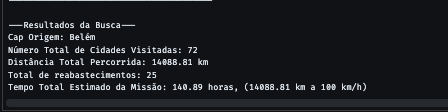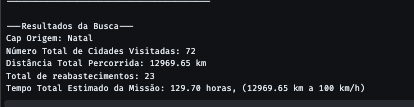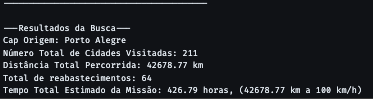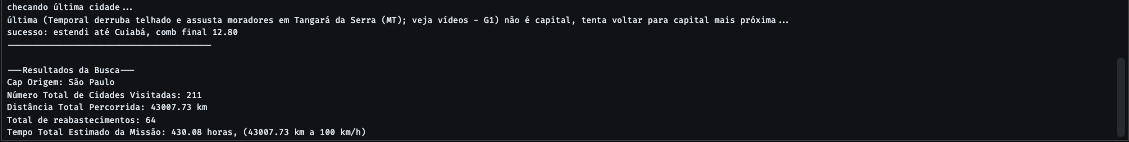

### **Visualização da Rota e Relatórios Detalhados**


Depois de encontrar a rota com o A*, eu criei algumas células só pra mostrar e entender o que rolou na missão:

1.	**Plotagem básica com Folium**

A função plot_rota_mapa recebe o DataFrame, a lista de índices da rota e o set de capitais, filtra só os pontos válidos e desenha:
-	Um PolyLine ligando todas as cidades na ordem da rota,
-	Marcadores agrupados por MarkerCluster (pra não lotar o mapa),
-	Ícones/vermelhos para capitais, azuis para cidades e um destaque verde para o ponto de partida.
Assim, em poucas linhas eu já tenho um mapa interativo que mostra o percurso completo.

2.	**Animação com ipyleaflet**

Na sequência, montei um bloco pra animar essa mesma rota passo a passo:
-	Constrói listas de coordenadas e de combustível chegando em cada nó,
-	Cria um Polyline que vai se esticando conforme o drone “voa”,
-	Adiciona um marcador simples e uma bolha de texto (com HTML) em cada etapa, indicando nome da cidade (na maioria é descrição do alagamento, só capitais ficam com nome certo), autonomia restante e se foi um reabastecimento numa capital.
-	Controla tudo com asyncio.sleep pra dar um ritmo de animação.
É um jeito divertido e bem claro de ver o drone passando de ponto em ponto.

3.	**Resumo textual por trechos**

Logo depois, imprimo no notebook um relatório dividido em trechos de reabastecimento (mantendo a lógica que um trecho é sempre de capital-capital):
-	Cada bloco TRECHO 1, TRECHO 2… mostra as cidades visitadas, autonomia de chegada e quando rolou o reabastecimento numa capital.
-	No fim de cada trecho, já abro o próximo, marcando “Partida do Trecho” com autonomia zerada — fica fácil acompanhar onde cada segmento começou e terminou.

4.	**Mapa de todas as cidades da amostra**

Por fim, pra ver todos os pontos antes da busca, ploto um mapa com todas as cidades do df:
-	Outro MarkerCluster, só marcando cada latitude/longitude,
-	Isso ajuda a entender a dispersão geográfica e vê onde os clusters de alagamentos estão concentrados.

Em conjunto, esses quatro blocos transformam o resultado bruto do A* em visualizações e relatórios acessíveis: dá pra navegar no mapa, assistir a animação do voo, conferir os detalhes de cada trecho e ainda enxergar o contexto geral da amostra.

In [ ]:
# função que desenha a rota no folium
def plot_rota_mapa(df_nodes, route_indices, capital_nodes_set_param):
    # se não tiver rota, reclama e sai
    if not route_indices:
        print("ERRO: rota vazia.")
        return None

    # pega só os índices válidos no dataframe
    id_rota_final = [idx for idx in route_indices if idx in df_nodes.index]
    if not id_rota_final:
        print(f"ERRO: len da rota: {len(id_rota_final)}")
        return None

    # centraliza mapa na média das coordenadas
    center = [df_nodes.lat.mean(), df_nodes.lon.mean()]
    m = folium.Map(location=center, zoom_start=4)

    # se tem pelo menos dois pontos, desenha a linha da rota
    route_coords = [(df_nodes.loc[idx, 'lat'], df_nodes.loc[idx, 'lon']) for idx in id_rota_final]
    if len(route_coords) > 1:
        folium.PolyLine(route_coords, color='darkgreen', weight=3.5, opacity=1.0).add_to(m)

    # agrupa marcadores pra não poluir o mapa
    marker_cluster = MarkerCluster().add_to(m)
    for idx in set(id_rota_final):
        lat, lon = df_nodes.loc[idx, ['lat', 'lon']]
        is_capital = df_nodes.loc[idx, 'is_cap']
        cidade_info = str(df_nodes.loc[idx, 'cidade'])

        # cores e ícones diferentes pra capitais e ponto inicial
        color = 'blue'
        icon_type = 'info-sign'
        if is_capital:
            cidade_info += ' (Capital)'
            color = 'red'
            icon_type = 'plane'
        if idx == id_rota_final[0]:
            color = 'green'

        folium.Marker(
            [lat, lon],
            popup=folium.Popup(cidade_info, max_width=300),
            icon=folium.Icon(color=color, icon=icon_type)
        ).add_to(marker_cluster)

    # destaca ponto de partida com círculo verde maior
    ini_idx = id_rota_final[0]
    ini_lat, ini_lon = df_nodes.loc[ini_idx, ['lat', 'lon']]
    folium.CircleMarker(
        [ini_lat, ini_lon],
        radius=10, fill=True, fill_opacity=0.6,
        popup=f"Ponto de Partida: {df_nodes.loc[ini_idx, 'cidade']}"
    ).add_to(m)

    return m

# se a rota existe, plota, senão avisa erro
if 'rota_global_final' in locals() and rota_global_final:
    print("\nPlotando a melhor rota...")
    if 'id_set_cap' not in locals():
        id_set_cap = set(nome_cap_para_id.values()) if 'nome_cap_para_id' in locals() else set()
    res_astar_mapa = plot_rota_mapa(df, rota_global_final, id_set_cap)
    if res_astar_mapa:
        display(res_astar_mapa)
else:
    print("\nERRO: não gerou a rota")


Plotando a melhor rota...


In [ ]:
if ('rota_global_final' in locals() and rota_global_final and
    'df' in locals() and
    'autonomia_astar' in locals() and autonomia_astar and
    len(rota_global_final) == len(autonomia_astar)):

    temp_fuel_map = {node_idx: autonomia_astar[i] for i, node_idx in enumerate(rota_global_final)}
    no_animado_filtered = [idx for idx in rota_global_final if idx in df.index]

    autonomia_p_animacao = []
    no_animado = []

    if no_animado_filtered:
        for idx in no_animado_filtered:
            if idx in temp_fuel_map:
                no_animado.append(idx)
                autonomia_p_animacao.append(temp_fuel_map[idx])
            else:
                print(f"Aviso: Nó {idx} de no_animado_filtered não encontrado no mapeamento de combustível. Será ignorado.")

    if not no_animado:
        print("ERRO: 'no_animado' vazio.")
    elif len(no_animado) != len(autonomia_p_animacao):
        print("ERRO: dados inconsistentes elif no_animado != autonomia_p_animacao.")
    else:
        coord_animacao = [(df.loc[node_idx, 'lat'], df.loc[node_idx, 'lon']) for node_idx in no_animado]

        if not coord_animacao:
            print("Error: Could not extract coordinates for the animation.")
        else:
            anim_centralizada = coord_animacao[0]
            ipyleaflet_map = Map(center=anim_centralizada, zoom=4, scroll_wheel_zoom=True)
            ipyleaflet_map.layout.height = '800px'
            ipyleaflet_map.layout.width = '100%'

            lin_animada = Polyline(locations=[], color="purple", fill=False, weight=3)
            ipyleaflet_map.add_layer(lin_animada)

            seg_texto = {'marker_ativo': None}

            async def animar_rota_on_map():
                for i, coord in enumerate(coord_animacao):
                    node_idx = no_animado[i]
                    cidade_nome = str(df.loc[node_idx, 'cidade'])
                    is_capital = df.loc[node_idx, 'is_cap']

                    fuel_value_at_node = autonomia_p_animacao[i]
                    fuel_text = f"{fuel_value_at_node:.2f}L"

                    no_mark = Marker(location=coord, draggable=False)
                    ipyleaflet_map.add_layer(no_mark)

                    lin_animada.locations = lin_animada.locations + [coord]
                    ipyleaflet_map.center = coord

                    if seg_texto['marker_ativo']:
                        try:
                            ipyleaflet_map.remove_layer(seg_texto['marker_ativo'])
                        except Exception as e_remove:
                            pass
                        seg_texto['marker_ativo'] = None

                    descricoes = [f"<div style='font-weight: bold;'>{cidade_nome}</div>", f"Combustível: {fuel_text}"]
                    if i == 0:
                        descricoes.append("(COMEÇO)")
                    elif is_capital:
                        descricoes.append("(REABASTECIMENTO)")
                    desc_html = "<br>".join(descricoes)

                    html = f"""
                    <div style="color: black;
                                background-color: rgba(255, 255, 255, 0.9);
                                border: 1px solid grey;
                                border-radius: 5px;
                                padding: 6px 8px;
                                font-size: 10pt;
                                font-family: Arial, sans-serif;
                                box-shadow: 3px 3px 5px rgba(0,0,0,0.4);
                                width: 230px;
                                z-index: 10000 !important;
                                ">
                        {desc_html}
                    </div>
                    """
                    text_label_icon = DivIcon(html=html, icon_size=None, icon_anchor=[0,0])

                    cur_marker_texto = Marker(location=coord, icon=text_label_icon, draggable=False)

                    ipyleaflet_map.add_layer(cur_marker_texto)
                    seg_texto['marker_ativo'] = cur_marker_texto

                    await asyncio.sleep(0.5)

                if seg_texto['marker_ativo']:
                    await asyncio.sleep(2.0)
                    try:
                        ipyleaflet_map.remove_layer(seg_texto['marker_ativo'])
                    except Exception:
                        pass
                    seg_texto['marker_ativo'] = None

            display(ipyleaflet_map)

            try:
                await animar_rota_on_map()
            except Exception as e:
                print(f"ERRO: animacao {e}")
else:
    error_messages = []
    if 'rota_global_final' not in locals() or not rota_global_final:
        error_messages.append("'rota_global_final' não definida ou vazia")
    if 'df' not in locals():
        error_messages.append("'df' DataFrame não definido")
    if 'autonomia_astar' not in locals() or not autonomia_astar:
        error_messages.append("'autonomia_astar' (lista de combustíveis) não gerada ou vazia")
    elif 'rota_global_final' in locals() and 'autonomia_astar' in locals() and len(rota_global_final) != len(autonomia_astar):
        error_messages.append("Inconsistência: Comprimento da rota e dos níveis de combustível não correspondem.")
    print(f"ERRO: {', '.join(error_messages)}.")


Map(center=[np.float64(-23.567387), np.float64(-46.570383)], controls=(ZoomControl(options=['position', 'zoom_…

In [ ]:
print("\n--- Rota Detalhada por Trechos de Reabastecimento ---")

if ('rota_global_final' in locals() and rota_global_final and
    'df' in locals() and
    'autonomia_astar' in locals() and autonomia_astar and
    len(rota_global_final) == len(autonomia_astar)):

    trecho_counter = 1

    for i, node_idx in enumerate(rota_global_final):
        is_capital = df.loc[node_idx, 'is_cap']

        if is_capital:
            show_nome = df.loc[node_idx, 'cidade']
        else:
            show_nome = f"Cidade (Índice: {node_idx})"

        # início do primeiro trecho
        if i == 0:
            print(f"\n## TRECHO {trecho_counter}")
            print(f"- {show_nome:<35} | Autonimia: {AUTONOMIA:.2f}Km (Origem da Rota)")
            continue

        auto_na_chegada = autonomia_astar[i]

        print(f"- {show_nome:<35} | Autonimia na Chegada: {auto_na_chegada:.2f}Km")

        if is_capital:
            if i == len(rota_global_final) - 1:
                print("  (Destino Final da Rota)")
            else:
                print("  (Fim do Trecho - Reabastecimento)")
                trecho_counter += 1
                print(f"\n## TRECHO {trecho_counter}")
                print(f"- {show_nome:<35} | Autonimia: {AUTONOMIA:.2f}Km (Partida do Trecho)")

else:
    print("ERRO: rota não válida")


--- Rota Detalhada por Trechos de Reabastecimento ---

## TRECHO 1
- São Paulo                           | Autonimia: 750.00Km (Origem da Rota)
- Cidade (Índice: 166)                | Autonimia na Chegada: 9.94Km
- Vitória                             | Autonimia na Chegada: 6.36Km
  (Fim do Trecho - Reabastecimento)

## TRECHO 2
- Vitória                             | Autonimia: 750.00Km (Partida do Trecho)
- Cidade (Índice: 200)                | Autonimia na Chegada: 434.70Km
- Cidade (Índice: 187)                | Autonimia na Chegada: 225.09Km
- Cidade (Índice: 183)                | Autonimia na Chegada: 163.90Km
- Cidade (Índice: 169)                | Autonimia na Chegada: 85.54Km
- Cidade (Índice: 168)                | Autonimia na Chegada: 66.05Km
- Vitória                             | Autonimia na Chegada: 58.38Km
  (Fim do Trecho - Reabastecimento)

## TRECHO 3
- Vitória                             | Autonimia: 750.00Km (Partida do Trecho)
- Cidade (Índice: 192)              

In [ ]:
print("\nMapa com todas as cidades da amostra:")
m_todos = folium.Map([-14.5931291,-56.6985808], zoom_start=4)
marker_cluster_todos = MarkerCluster().add_to(m_todos)

for index_df, row_df in tqdm(df.iterrows(), total=len(df)):
  lat_val = row_df['lat']
  lon_val = row_df['lon']
  text_val = row_df['cidade']
  folium.Marker([lat_val, lon_val], popup=text_val).add_to(marker_cluster_todos)

display(m_todos)


Mapa com todas as cidades da amostra:


100%|██████████| 318/318 [00:00<00:00, 8408.39it/s]
